I'll be showing how the HSAR userclass works and comparing the results from OLS and the HSAR in estimating effects for the example data provided.

In [1]:
import hlm
import pysal as ps
import pandas as pd
import numpy as np

In [3]:
data = pd.read_csv('./test.csv')

In [4]:
data.head()

,id,u.full,y,x,county
0,0,-0.689048,0.788457,1,1
1,1,-0.689048,0.788457,0,1
2,2,-0.689048,1.064711,0,1
3,3,-0.689048,0.000000,0,1
4,4,-0.847313,1.131402,0,2


In [5]:
y = data[['y']].values
X = data[['x']].values

In [6]:
W = ps.open('./w_lower.mtx').read()
M = ps.open('./w_upper.mtx').read()
W.transform = M.transform = 'r'

In [7]:
membership = data[['county']].values - 1

In [8]:
ols = ps.spreg.OLS(y,X,W)

In [9]:
pd.DataFrame(np.hstack((ols.betas, ols.std_err.reshape(ols.betas.shape))),
             columns=['$\\beta$', '$\sigma_\\beta$'])

,$\beta$,$\sigma_\beta$
0,1.326744,0.029721
1,-0.613395,0.072841


Thus, if we just estimate these naively via ols, this is what we get

### The Dong Harris HSAR

The user class will take 1000 samples if you don't pass a `cycles` argument. So, just to show how the user class works, I'll set it up but not start the sampler.

In [10]:
dh = hlm.HSAR(y,X,W,M,membership=membership, cycles=0)

hlm/dong_harris/verify.py:47: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 1; dimension is 85 but corresponding boolean dimension is 1
  Delta[membership == region] = 1
hlm/dong_harris/verify.py:66: UserWarning: Computing grid of log determinants on demand may take a while
  Warn("Computing grid of log determinants on demand may take a while")
/home/ljw/.local/lib/python2.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:237: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


The public methods and attributes in the sampler are:

In [ ]:
[x for x in dir(dh) if not x.startswith('_')]

a short summary from the full specification document in `hlm/spec.md`:

parameter set: 
- `front` : front sample of parameters
- `current`: current sample of parameters
- `previous`: previous sample of parameters

movement:
- `cycle`: compute one sample, either full or partial
- `step`: take one draw from the sampler and increment the position by 1
- `sample`: take an arbitrary number of cycles or steps

indexing:
- `position`: current position within a full cycle
- `cycles`: number of full perfect samples drawn
- `steps`: number of times that the position has been incremented

data & configuration:
- `hypers` : namespace containing hyperparameters used for model
- `samplers`: list of samplers being used 
- `trace`: collection of previous samples
- `var_names` : names of the samplers

In [11]:
dh.sample(cycles=1000)

In [12]:
np.vstack(dh.trace.Betas).mean(axis=0)

array([ 1.38036217, -0.60808814])

And so we get a slightly larger constant and an effect that's quite close. The standard errors are:

In [13]:
np.sqrt(np.vstack(dh.trace.Betas).var(axis=0))

array([ 0.22446331,  0.07720187])

Much larger for the constant, but about the same for the estimated effect. 

In [14]:
np.vstack(dh.trace.Betas).mean(axis=0)

array([ 1.38036217, -0.60808814])

In [15]:
np.sqrt(np.vstack(dh.trace.Betas).var(axis=0))

array([ 0.22446331,  0.07720187])

Now, where this gets nice is that we can make plots of the posterior predictive distributions. We could do this with OLS, too, since each $\hat{\beta} \sim \mathcal{N}(\beta, SE_\hat{\beta})$, but...

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_context('poster')

/home/ljw/.local/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


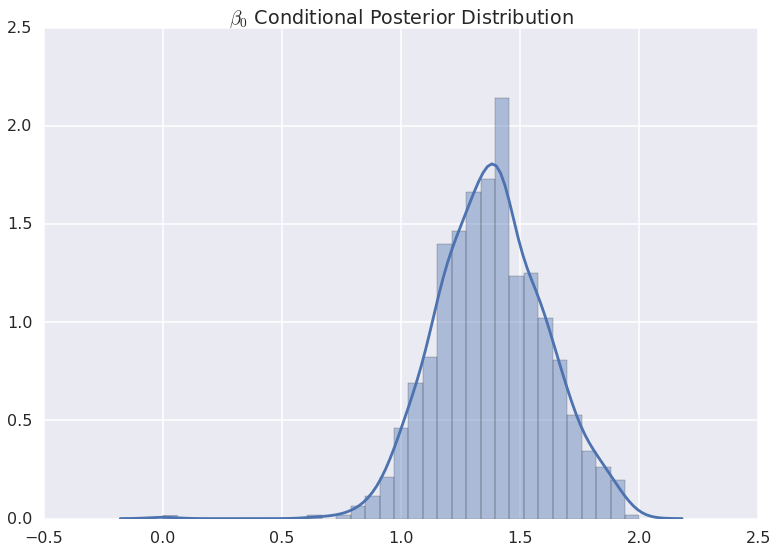

In [17]:
sns.distplot(np.vstack(dh.trace.Betas).T[0])
plt.title('$\\beta_0$ Conditional Posterior Distribution')

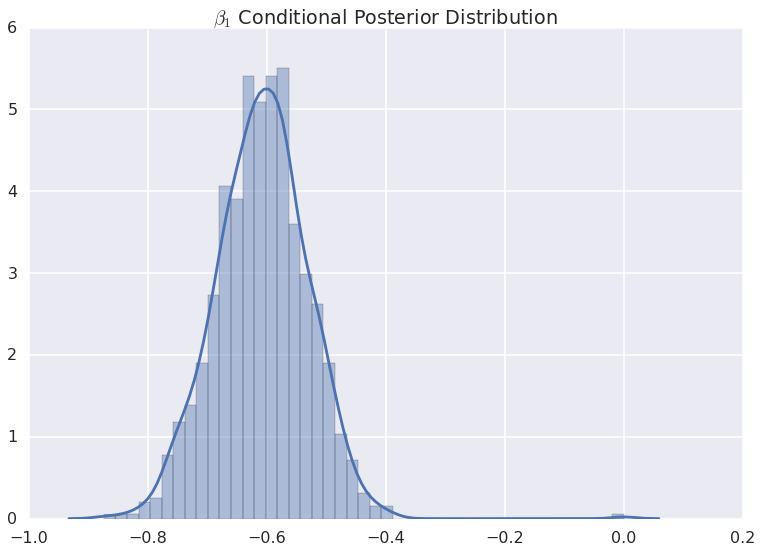

In [18]:
sns.distplot(np.vstack(dh.trace.Betas).T[1])
plt.title('$\\beta_1$ Conditional Posterior Distribution')

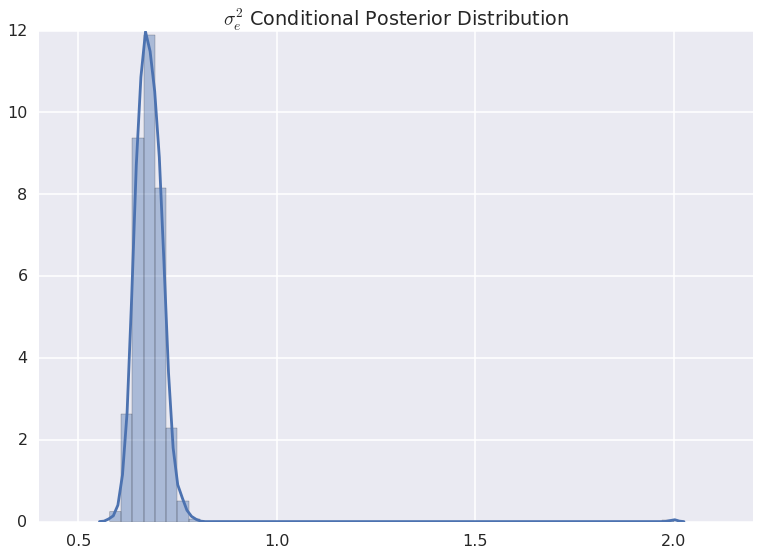

In [20]:
sns.distplot(np.vstack(dh.trace.Sigma2_e))
plt.title('$\\sigma_e^2$ Conditional Posterior Distribution')

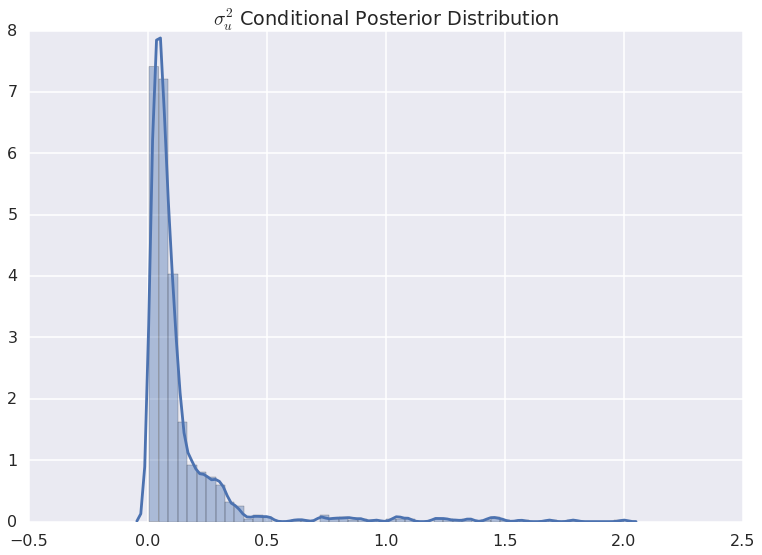

In [21]:
sns.distplot(np.vstack(dh.trace.Sigma2_u))
plt.title('$\\sigma_u^2$ Conditional Posterior Distribution')

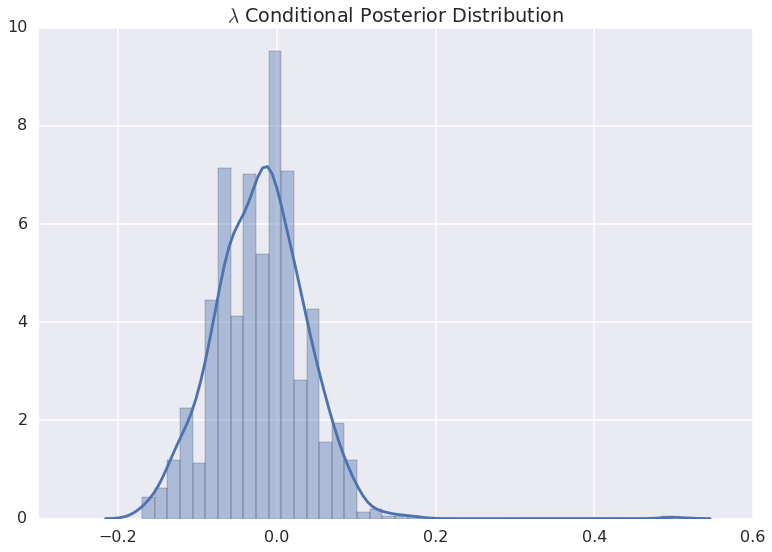

In [22]:
sns.distplot(np.vstack(dh.trace.Rho))
plt.title('$\\lambda$ Conditional Posterior Distribution')

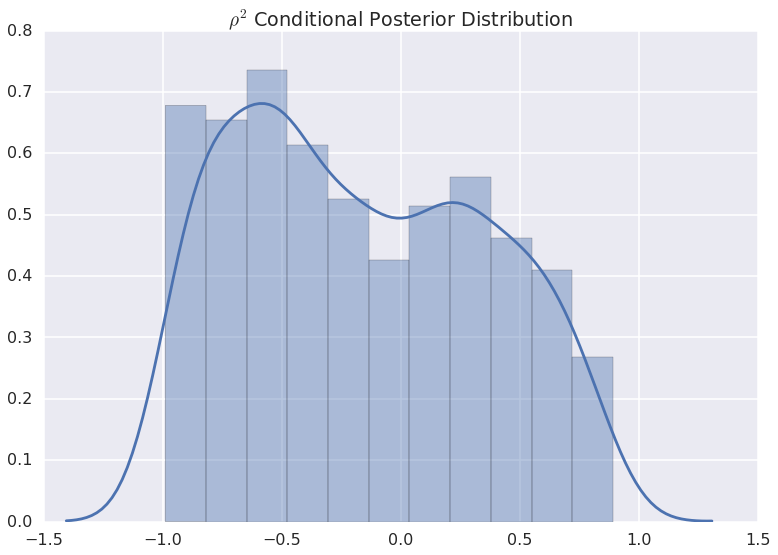

In [23]:
sns.distplot(np.vstack(dh.trace.Lambda))
plt.title('$\\rho^2$ Conditional Posterior Distribution')

In [24]:
dhchol = hlm.HSAR(y,X,W,M,membership=membership, cycles=5000)

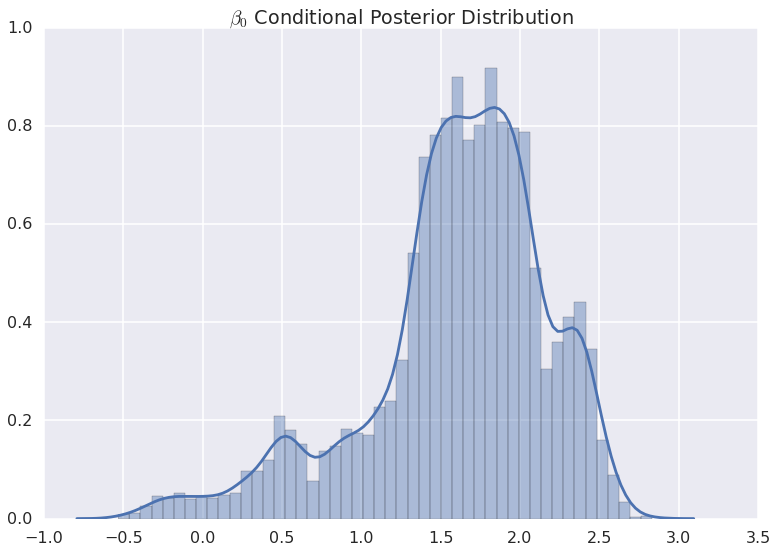

In [25]:
sns.distplot(np.vstack(dhchol.trace.Betas).T[0])
plt.title('$\\beta_0$ Conditional Posterior Distribution')

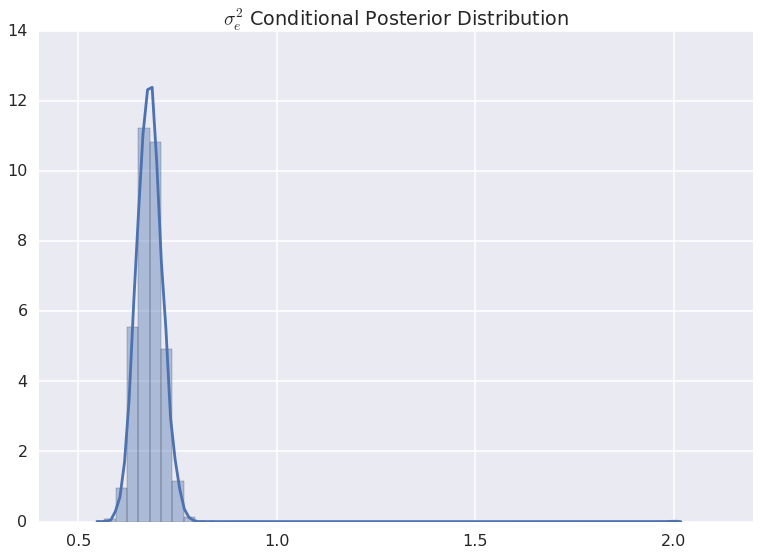

In [27]:
sns.distplot(np.vstack(dhchol.trace.Sigma2_e))
plt.title('$\\sigma_e^2$ Conditional Posterior Distribution')

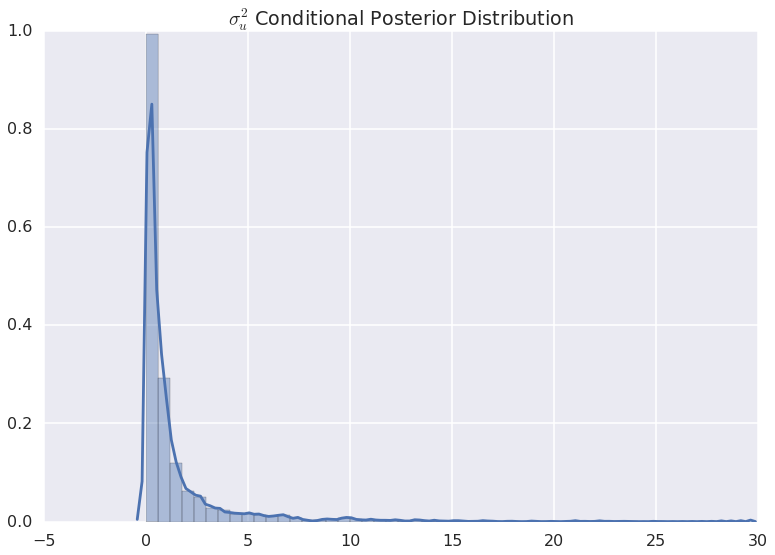

In [28]:
sns.distplot(np.vstack(dhchol.trace.Sigma2_u))
plt.title('$\\sigma_u^2$ Conditional Posterior Distribution')

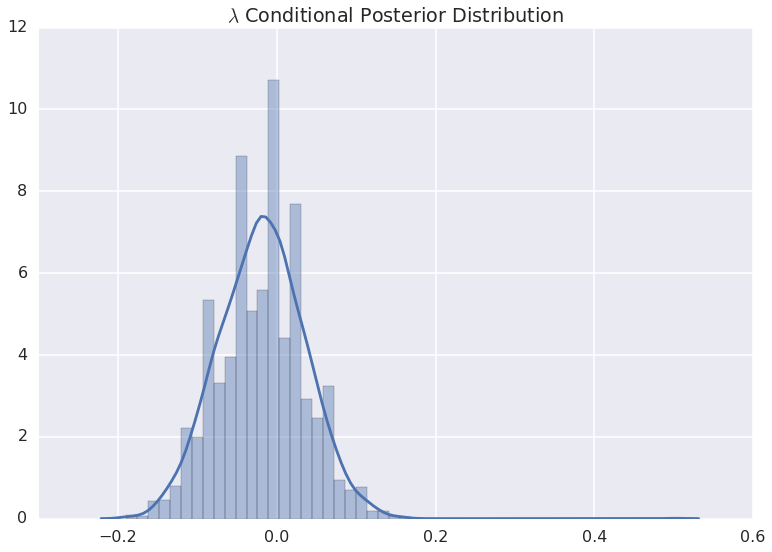

In [29]:
sns.distplot(np.vstack(dhchol.trace.Rho))
plt.title('$\\lambda$ Conditional Posterior Distribution')

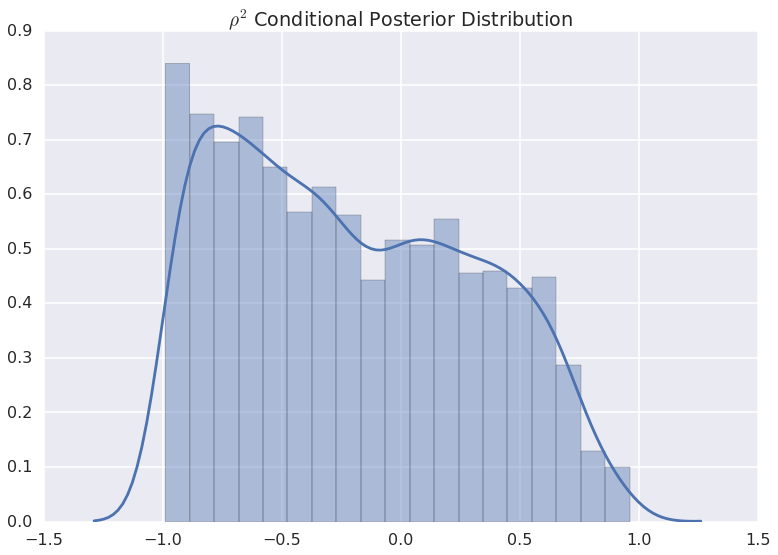

In [30]:
sns.distplot(np.vstack(dhchol.trace.Lambda))
plt.title('$\\rho^2$ Conditional Posterior Distribution')